# Convergence analysis for the standing mode example

Data for the standing mode wave:
$$
\begin{aligned}
&\textbf{Domain:} && \Omega = [0, 1] \times [0, 1] \\
&\textbf{Final time:} && T = 1.0 \\
&\textbf{Number of elements:} && N_{\text{el},x} = N_{\text{el},y} = 320 \\
&\textbf{Polynomial degree:} && r = 1 \\
&\textbf{Time step:} && \Delta t = 0.01 \\
&\textbf{Wave speed:} && c(x, y, t) = 1.0 \\
&\textbf{Source:} && f(x, y, t) = 0 \\
&\textbf{Initial displacement:} && u_0(x, y) = \sin(\pi x)\sin(\pi y) \\
&\textbf{Initial velocity:} && v_0(x, y) = 0 \\
&\textbf{Boundary conditions:} && g(x, y, t) = 0 \\
&\textbf{Time derivative of boundary:} && \frac{\partial g}{\partial t}(x, y, t) = 0 \\
&\textbf{Exact solution:} && u_{\text{exact}}(x, y, t) = \cos(\sqrt{2}\pi t)\sin(\pi x)\sin(\pi y) \\
\end{aligned}
$$


## Newmark

Diverging configurations are not shown in the plots.


In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.colors as colors
import numpy as np

sns.set_theme(style="whitegrid")

# Threshold for flagging divergence
DIVERGENCE_THRESHOLD = 1.0e5

In [163]:
def filter_diverged(df, threshold=DIVERGENCE_THRESHOLD):
    """
    Remove rows where error >= threshold and report diverged configurations.
    Returns cleaned dataframe and list of diverged configs.
    """
    df = df.copy()
    diverged = []
    
    for col in ['rel_L2_error_final', 'rel_H1_error_final']:
        if col in df.columns:
            # Handle NaN and inf
            df[col] = df[col].replace([np.inf, -np.inf], threshold * 10)
            df[col] = df[col].fillna(threshold * 10)
    
    # Find diverged rows
    mask_diverged = (df['rel_L2_error_final'] >= threshold) | (df['rel_H1_error_final'] >= threshold)
    if mask_diverged.any():
        diverged = df[mask_diverged][['N_el_x', 'N_el_y', 'r', 'dt']].drop_duplicates().values.tolist()
    
    # Return cleaned (non-diverged) dataframe
    return df[~mask_diverged], diverged

# Style map: order -> (color, linestyle)
_REF_STYLES = {
    1: ('tab:red',    '--'),
    2: ('tab:blue',   '-.'),
    3: ('tab:green',  ':'),
    4: ('tab:purple', '--'),
}
COLOR_PALETTE_TIME = "rocket"#"Blues_r" #"dark:salmon"
COLOR_PALETTE_SPACE = "viridis"#"Greens_r"

def _add_ref_slope(ax, sub, x_col, y_col, order, var_name='x', offset=0.5,
                   inline_label=False):
    """Draw a reference line with the given power-law slope.

    The constant *C* in  y = C · x^order  is chosen so that the line sits
    entirely **below** every data point (lower envelope), then shifted down
    by *offset* for visual clearance.  The line is clipped so it never
    extends below the global data minimum × offset.

    Parameters
    ----------
    inline_label : bool
        If True, annotate the line with a small text label directly on the
        plot (no legend entry).  If False (default), add a legend entry.
    """
    x_vals = np.sort(sub[x_col].unique())
    if len(x_vals) < 2:
        return

    # --- lower-envelope constant: C = min_i(y_i / x_i^order) · offset ----
    pts = sub[[x_col, y_col]].dropna()
    pts = pts[pts[x_col] > 0]
    pts = pts[pts[y_col] > 0]
    if len(pts) < 2:
        return
    ratios = pts[y_col].values / (pts[x_col].values ** order)
    C = ratios.min() * offset              # sit below the lowest point

    y_ref = C * (x_vals ** order)

    # --- clip: don't extend below the global data minimum · offset --------
    global_y_min = pts[y_col].min()
    floor = global_y_min * offset
    mask = y_ref >= floor
    if mask.sum() < 2:                     # always keep at least 2 points
        mask = np.zeros_like(mask, dtype=bool)
        mask[-2:] = True
    x_vals = x_vals[mask]
    y_ref = y_ref[mask]

    # --- per-order colour / dash style ------------------------------------
    color, ls = _REF_STYLES.get(order, ('gray', '--'))

    exp = '' if order == 1 else f'^{{{order}}}'
    label_text = f'$\\mathcal{{O}}({var_name}{exp})$'

    if inline_label:
        ax.plot(x_vals, y_ref, color=color, linestyle=ls,
                linewidth=1.5, alpha=0.7, label='_nolegend_')
        # place annotation near the left end of the short segment
        ax.annotate(
            label_text,
            xy=(x_vals[0], y_ref[0]),
            fontsize=14, color=color, fontweight='bold',
            va='top', ha='left',
            xytext=(14, 10), textcoords='offset points',
        )
    else:
        ax.plot(x_vals, y_ref, color=color, linestyle=ls,
                linewidth=1.5, alpha=0.7, label=label_text)

def plot_lines_by_r(df, scheme_name, r_per_row=2, ref_dt_order=None):
    """Single-row layout (4x1 for r_per_row=2), grouped by metric: L2 then H1."""
    df_clean, diverged = filter_diverged(df)
    figs_local = []
    if df_clean.empty or 'r' not in df_clean.columns:
        return figs_local

    # Pre-compute all unique h values globally to ensure consistent colors
    all_h_values = sorted(df_clean['h'].unique())
    h_palette = sns.color_palette(COLOR_PALETTE_TIME, len(all_h_values))
    h_to_color = {str(h): color for h, color in zip(all_h_values, h_palette)}

    r_vals = sorted(df_clean['r'].unique())
    for k in range(0, len(r_vals), r_per_row):
        r_group = r_vals[k:k + r_per_row]
        ncols = len(r_group)

        fig, axes = plt.subplots(1, 2 * ncols, figsize=(5 * 2 * ncols, 5), sharex=False, sharey=False)
        axes = np.array(axes).reshape(1, -1)

        l2_axes = [axes[0, j] for j in range(ncols)]
        h1_axes = [axes[0, ncols + j] for j in range(ncols)]

        for j, r_val in enumerate(r_group):
            sub = df_clean[df_clean['r'] == r_val].copy()
            if sub.empty:
                continue
            sub['h_label'] = sub['h'].astype(str)

            ax_l2 = l2_axes[j]
            ax_h1 = h1_axes[j]

            l2_legend = 'full' if (j == 0) else False
            sns.lineplot(
                data=sub, x='dt', y='rel_L2_error_final',
                hue='h_label', style='h_label', dashes=False,
                ax=ax_l2, legend=l2_legend, linewidth=2, marker="o",
                palette=h_to_color
            )
            sns.lineplot(
                data=sub, x='dt', y='rel_H1_error_final',
                hue='h_label', style='h_label', dashes=False,
                ax=ax_h1, legend=False, linewidth=2, marker="o",
                palette=h_to_color
            )

            ax_l2.set_title(f'L2 (r={r_val})')
            ax_h1.set_title(f'H1 (r={r_val})')

            for ax in (ax_l2, ax_h1):
                ax.set_xscale('log'); ax.set_yscale('log')
                ax.set_xlabel('dt')

            # Reference convergence rate line (temporal -> legend entry)
            if ref_dt_order is not None:
                _add_ref_slope(ax_l2, sub, 'dt', 'rel_L2_error_final', ref_dt_order, var_name='\\Delta t')
                _add_ref_slope(ax_h1, sub, 'dt', 'rel_H1_error_final', ref_dt_order, var_name='\\Delta t')

            ax_l2.set_ylabel('rel L2 error' if j == 0 else '')
            ax_h1.set_ylabel('rel H1 error' if j == 0 else '')

        # One legend below, dedup labels (collect from ALL axes for ref lines)
        all_handles, all_labels = [], []
        for ax in axes.ravel():
            h, l = ax.get_legend_handles_labels()
            all_handles.extend(h)
            all_labels.extend(l)
        for ax in axes.ravel():
            if ax.get_legend() is not None:
                ax.get_legend().remove()
        uniq = []
        seen = set()
        for h, l in zip(all_handles, all_labels):
            if l == 'h_label':
                continue
            if l in seen:
                continue
            seen.add(l)
            uniq.append((h, l))
        if uniq:
            h2, l2 = zip(*uniq)
            fig.legend(
                h2, l2, title='h',
                loc='lower center', bbox_to_anchor=(0.5, -0.02),
                ncol=min(len(l2), 6), frameon=True,
                borderaxespad=0.1, columnspacing=0.8, handletextpad=0.4
            )

        fig.suptitle(f'{scheme_name}: Error vs dt', y=0.9)
        fig.tight_layout(rect=[0, 0.06, 1, 0.94])
        figs_local.append(fig)
    return figs_local

def plot_lines_by_r_spatial(df, scheme_name, r_per_row=2, ref_h=True):
    """Like plot_lines_by_r but with h on x-axis and dt as colour."""
    df_clean, diverged = filter_diverged(df)
    figs_local = []
    if df_clean.empty or 'r' not in df_clean.columns:
        return figs_local

    # Pre-compute all unique dt values globally to ensure consistent colors
    all_dt_values = sorted(df_clean['dt'].unique())
    dt_palette = sns.color_palette(COLOR_PALETTE_SPACE, len(all_dt_values))
    dt_to_color = {str(dt): color for dt, color in zip(all_dt_values, dt_palette)}

    r_vals = sorted(df_clean['r'].unique())
    for k in range(0, len(r_vals), r_per_row):
        r_group = r_vals[k:k + r_per_row]
        ncols = len(r_group)

        fig, axes = plt.subplots(1, 2 * ncols, figsize=(5 * 2 * ncols, 5), sharex=False, sharey=False)
        axes = np.array(axes).reshape(1, -1)

        l2_axes = [axes[0, j] for j in range(ncols)]
        h1_axes = [axes[0, ncols + j] for j in range(ncols)]

        for j, r_val in enumerate(r_group):
            sub = df_clean[df_clean['r'] == r_val].copy()
            if sub.empty:
                continue
            sub['dt_label'] = sub['dt'].astype(str)

            ax_l2 = l2_axes[j]
            ax_h1 = h1_axes[j]

            l2_legend = 'full' if (j == 0) else False
            sns.lineplot(
                data=sub, x='h', y='rel_L2_error_final',
                hue='dt_label', style='dt_label', dashes=False,
                ax=ax_l2, legend=l2_legend, linewidth=2, marker='o',
                palette=dt_to_color
            )
            sns.lineplot(
                data=sub, x='h', y='rel_H1_error_final',
                hue='dt_label', style='dt_label', dashes=False,
                ax=ax_h1, legend=False, linewidth=2, marker='o',
                palette=dt_to_color
            )

            ax_l2.set_title(f'L2 (r={r_val})')
            ax_h1.set_title(f'H1 (r={r_val})')
            for ax in (ax_l2, ax_h1):
                ax.set_xscale('log'); ax.set_yscale('log')
                ax.set_xlabel('h')

            # Reference convergence rate lines: h^{r+1} for L2, h^r for H1
            # Use inline labels (no legend entry) since orders differ per panel
            if ref_h:
                _add_ref_slope(ax_l2, sub, 'h', 'rel_L2_error_final', r_val + 1,
                               var_name='h', inline_label=True)
                _add_ref_slope(ax_h1, sub, 'h', 'rel_H1_error_final', r_val,
                               var_name='h', inline_label=True)

            ax_l2.set_ylabel('rel L2 error' if j == 0 else '')
            ax_h1.set_ylabel('rel H1 error' if j == 0 else '')

        # Legend (dt values only – ref slopes use inline annotations)
        all_handles, all_labels = [], []
        for ax in axes.ravel():
            h, l = ax.get_legend_handles_labels()
            all_handles.extend(h)
            all_labels.extend(l)
        for ax in axes.ravel():
            if ax.get_legend() is not None:
                ax.get_legend().remove()
        uniq = []
        seen = set()
        for h, l in zip(all_handles, all_labels):
            if l == 'dt_label':
                continue
            if l in seen:
                continue
            seen.add(l)
            uniq.append((h, l))
        if uniq:
            h2, l2 = zip(*uniq)
            fig.legend(
                h2, l2, title='dt',
                loc='lower center', bbox_to_anchor=(0.5, -0.02),
                ncol=min(len(l2), 8), frameon=True,
                borderaxespad=0.1, columnspacing=0.8, handletextpad=0.4
            )

        fig.suptitle(f'{scheme_name}: Error vs h', y=0.9)
        fig.tight_layout(rect=[0, 0.06, 1, 0.94])
        figs_local.append(fig)
    return figs_local


In [164]:
def _safe_slope_loglog(x, y):
    """Return slope of log(y) vs log(x) (least squares), or NaN if not enough points."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    x = x[mask]; y = y[mask]
    if x.size < 2:
        return float('nan')
    lx = np.log(x); ly = np.log(y)
    A = np.vstack([lx, np.ones_like(lx)]).T
    m, _b = np.linalg.lstsq(A, ly, rcond=None)[0]
    return float(m)

def _ref_line(ax, x, x0, y0, p, label):
    x = np.asarray(x, dtype=float)
    y = y0 * (x / x0) ** p
    ax.plot(x, y, '--', linewidth=2, label=label)

def plot_spacetime_rates(df, scheme_name, err_col):
    """
    For each r:
      - plot error vs h at dt=min(dt) with reference h^(r+1) for L2 or h^r for H1
      - plot error vs dt at h=min(h) with reference dt^2 or dt^1 depending on scheme
    Also prints observed slopes.
    """
    dfc, _ = filter_diverged(df)
    if dfc.empty:
        print(f"[{scheme_name}] no data")
        return

    # Determine temporal order based on scheme name
    # Newmark and CN (Theta=0.5) are 2nd order. Theta=0/1 are 1st order.
    if "Theta=1.0" in scheme_name or "Theta=0.0" in scheme_name or "BE" in scheme_name or "FE" in scheme_name:
        t_order = 1.0
    else:
        t_order = 2.0

    # Ensure numeric types
    dfc = dfc.copy()
    for c in ['h', 'dt', 'r', err_col]:
        dfc[c] = pd.to_numeric(dfc[c], errors='coerce')
    dfc = dfc.dropna(subset=['h', 'dt', 'r', err_col])

    r_vals = sorted(dfc['r'].unique())
    for r_val in r_vals:
        subr = dfc[dfc['r'] == r_val].copy()
        if subr.empty:
            continue

        # Determine spatial order based on metric
        if 'L2' in err_col:
            s_order = float(r_val) + 1.0
        else:
            s_order = float(r_val)

        dt_min = float(subr['dt'].min())
        h_min = float(subr['h'].min())

        sub_h = subr[subr['dt'] == dt_min].sort_values('h')
        sub_t = subr[subr['h'] == h_min].sort_values('dt')

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # ---- error vs h (dt fixed) ----
        ax = axes[0]
        
        label_h = f'dt={dt_min:g}'
        if len(sub_h) >= 2:
            slope_h = _safe_slope_loglog(sub_h['h'], sub_h[err_col])
            if not np.isnan(slope_h):
                label_h += f', slope~{slope_h:.2f}'

        ax.plot(sub_h['h'], sub_h[err_col], marker='o', linewidth=2, label=label_h)
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.set_xlabel('h'); ax.set_ylabel(err_col)
        ax.set_title(f"{scheme_name} | r={int(r_val)} | spatial (dt=min)")
        
        # Reference h^s_order scaled on first point
        if len(sub_h) >= 1:
            x0 = float(sub_h['h'].iloc[0]); y0 = float(sub_h[err_col].iloc[0])
            _ref_line(ax, sub_h['h'].values, x0, y0, s_order, f"~ h^{int(s_order)}")
        ax.legend(loc='upper left')

        # ---- error vs dt (h fixed) ----
        ax = axes[1]
        
        label_t = f'h={h_min:g}'
        if len(sub_t) >= 2:
            slope_dt = _safe_slope_loglog(sub_t['dt'], sub_t[err_col])
            if not np.isnan(slope_dt):
                label_t += f', slope~{slope_dt:.2f}'

        ax.plot(sub_t['dt'], sub_t[err_col], marker='o', linewidth=2, label=label_t)
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.set_xlabel('dt'); ax.set_ylabel(err_col)
        ax.set_title(f"{scheme_name} | r={int(r_val)} | temporal (h=min)")
        
        # Reference dt^t_order scaled on first point
        if len(sub_t) >= 1:
            x0 = float(sub_t['dt'].iloc[0]); y0 = float(sub_t[err_col].iloc[0])
            _ref_line(ax, sub_t['dt'].values, x0, y0, t_order, f"~ dt^{int(t_order)}")
        ax.legend(loc='upper left')

        fig.tight_layout()


In [165]:
# ------------------------------------------------------------------
# Load unified convergence CSV (all 5 schemes in one file)
# ------------------------------------------------------------------
csv_path = Path('convergence-results.csv')
df_all = pd.read_csv(csv_path)

# Normalise types
for col in ['h', 'dt', 'T', 'rel_L2_error_final', 'rel_H1_error_final', 'elapsed_time_s']:
    df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
for col in ['N_el_x', 'N_el_y', 'r']:
    df_all[col] = pd.to_numeric(df_all[col], errors='coerce').astype('Int64')
for col in ['theta', 'beta', 'gamma']:
    df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

# Drop exact duplicates (keep last)
dedup_cols = ['h', 'N_el_x', 'N_el_y', 'r', 'dt', 'T', 'method', 'theta', 'beta', 'gamma']
df_all = df_all.drop_duplicates(subset=dedup_cols, keep='last')

# Split into method families
df_theta   = df_all[df_all['method'].str.contains('theta', na=False)].copy()
df_newmark = df_all[df_all['method'].str.contains('newmark', na=False)].copy()

# Newmark subsets
df_newmark_025 = df_newmark[df_newmark['beta'] == 0.25].copy()
df_newmark_000 = df_newmark[df_newmark['beta'] == 0.0].copy()

# Theta subsets
df_theta_FE = df_theta[df_theta['theta'] == 0.0].copy()
df_theta_CN = df_theta[df_theta['theta'] == 0.5].copy()
df_theta_BE = df_theta[df_theta['theta'] == 1.0].copy()

print(f"Total rows: {len(df_all)}")
print(f"Total run time: {df_all['elapsed_time_s'].sum():.6} s")
print(f"\n=== Newmark ===")
print(f"  beta=0.25 : {len(df_newmark_025)} rows")
print(f"  beta=0.0  : {len(df_newmark_000)} rows")
print(f"\n=== Theta ===")
print(f"  FE (theta=0.0): {len(df_theta_FE)} rows")
print(f"  CN (theta=0.5): {len(df_theta_CN)} rows")
print(f"  BE (theta=1.0): {len(df_theta_BE)} rows")

Total rows: 421
Total run time: 6214.04 s

=== Newmark ===
  beta=0.25 : 99 rows
  beta=0.0  : 54 rows

=== Theta ===
  FE (theta=0.0): 54 rows
  CN (theta=0.5): 107 rows
  BE (theta=1.0): 107 rows


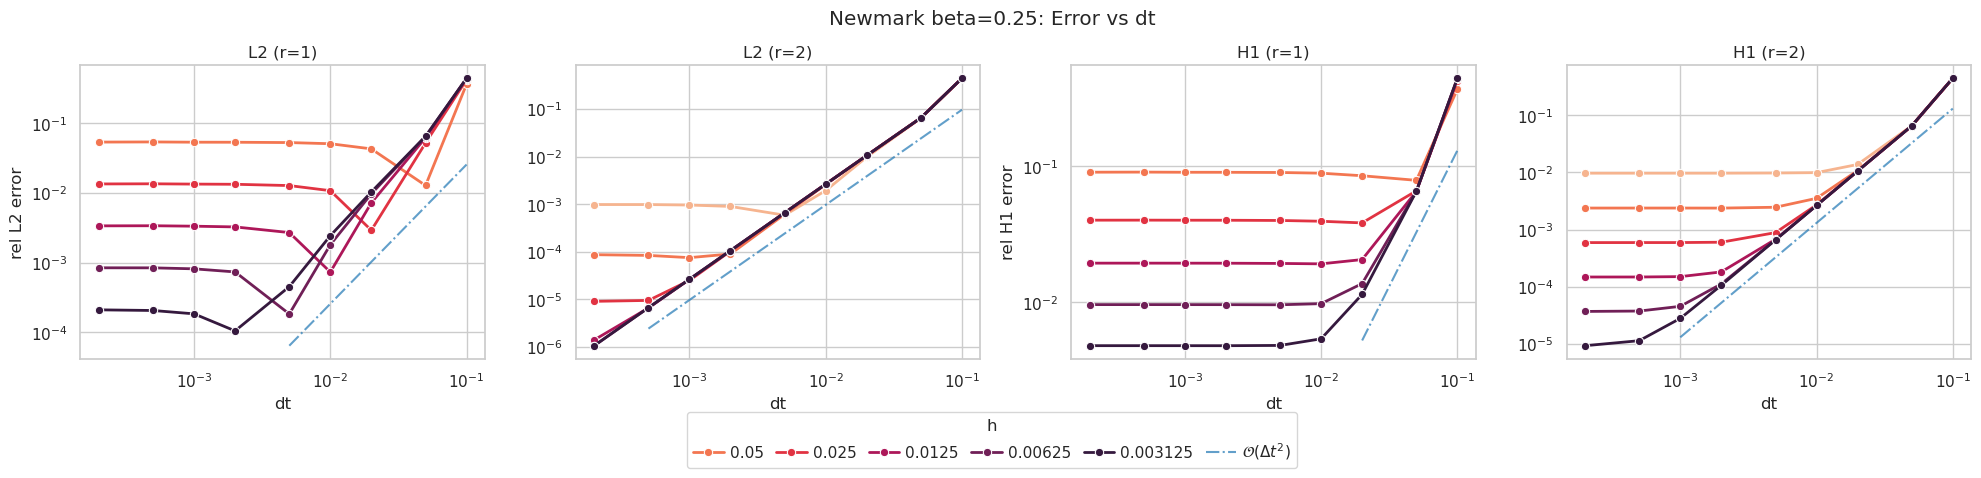

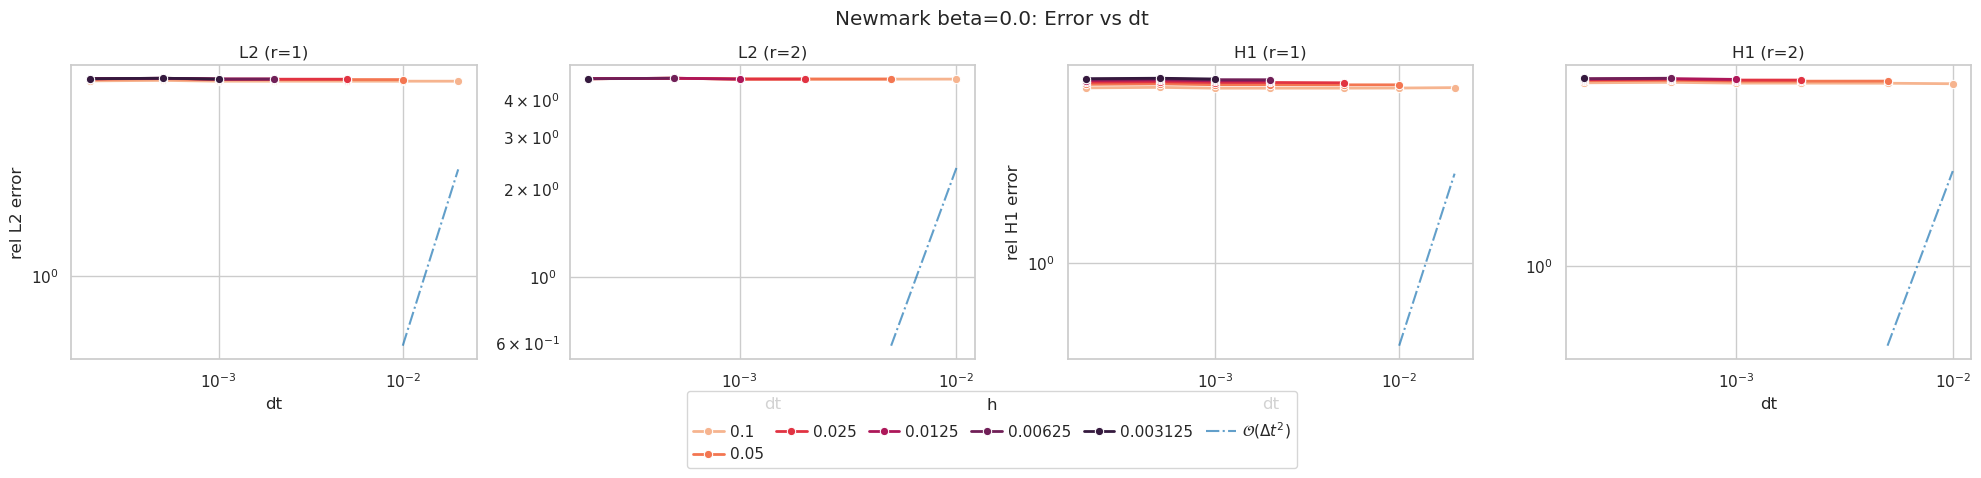

In [166]:
# Line charts for Newmark subsets
figs_nmk_025 = plot_lines_by_r(df_newmark_025, 'Newmark beta=0.25', ref_dt_order=2)
print()
figs_nmk_000 = plot_lines_by_r(df_newmark_000, 'Newmark beta=0.0', ref_dt_order=2)

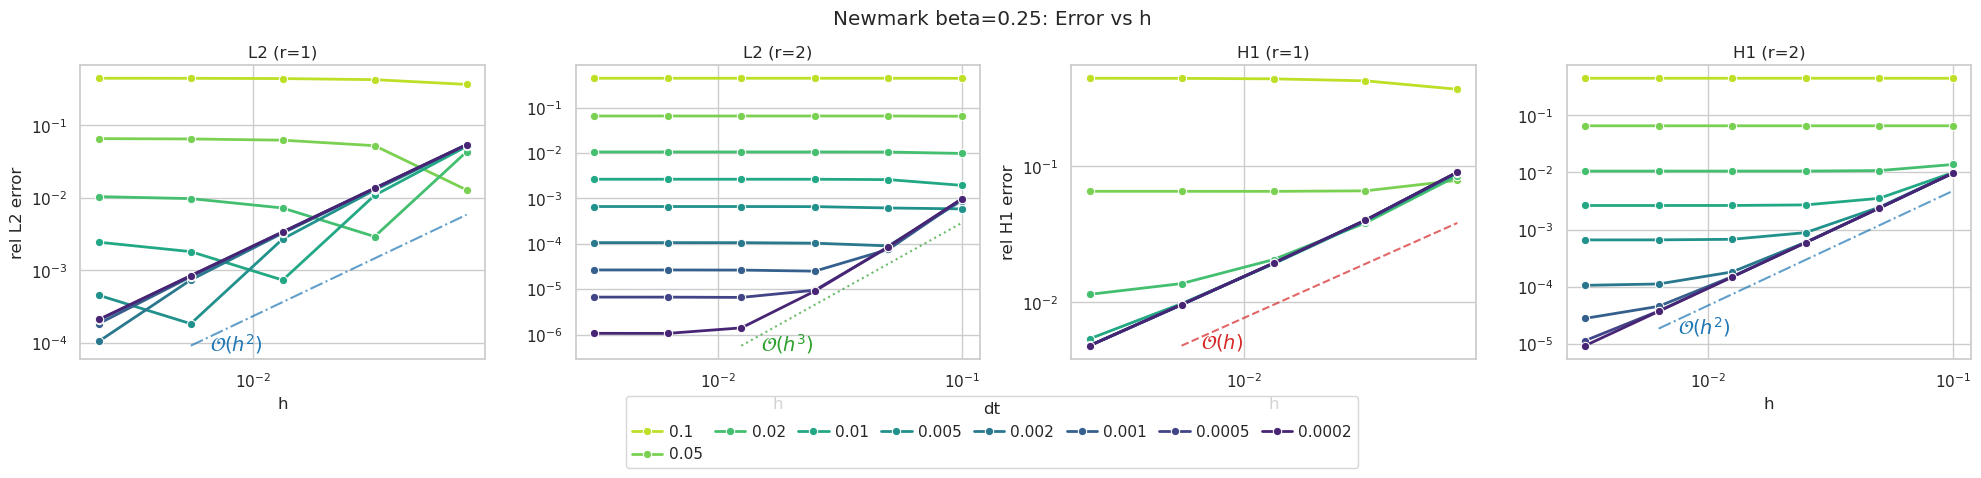

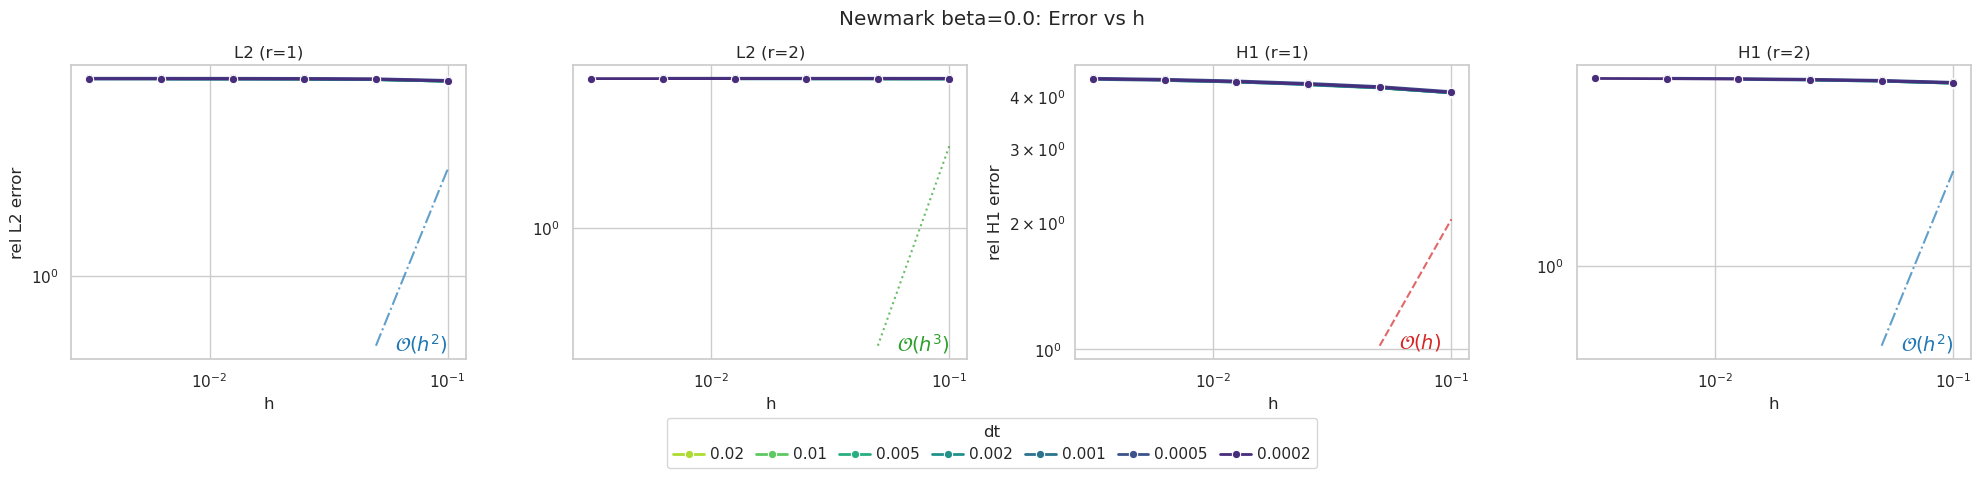

In [167]:
# Spatial line charts for Newmark subsets (h on x-axis, dt as colour)
g = plot_lines_by_r_spatial(df_newmark_025, 'Newmark beta=0.25')
print()
g = plot_lines_by_r_spatial(df_newmark_000, 'Newmark beta=0.0')

In [168]:
# # Rate-style plots: isolate h^r and dt^2 behavior (Newmark)
# plot_spacetime_rates(df_newmark_025, 'Newmark beta=0.25', 'rel_L2_error_final')
# plot_spacetime_rates(df_newmark_025, 'Newmark beta=0.25', 'rel_H1_error_final')

# plot_spacetime_rates(df_newmark_000, 'Newmark beta=0.0', 'rel_L2_error_final')
# plot_spacetime_rates(df_newmark_000, 'Newmark beta=0.0', 'rel_H1_error_final')

In [169]:
# # Heatmaps for Newmark subsets
# plot_heatmaps(df_newmark_025, 'Newmark beta=0.25')
# print()
# plot_heatmaps(df_newmark_000, 'Newmark beta=0.0')

## Theta method

Diverging configurations are not shown in the plots.

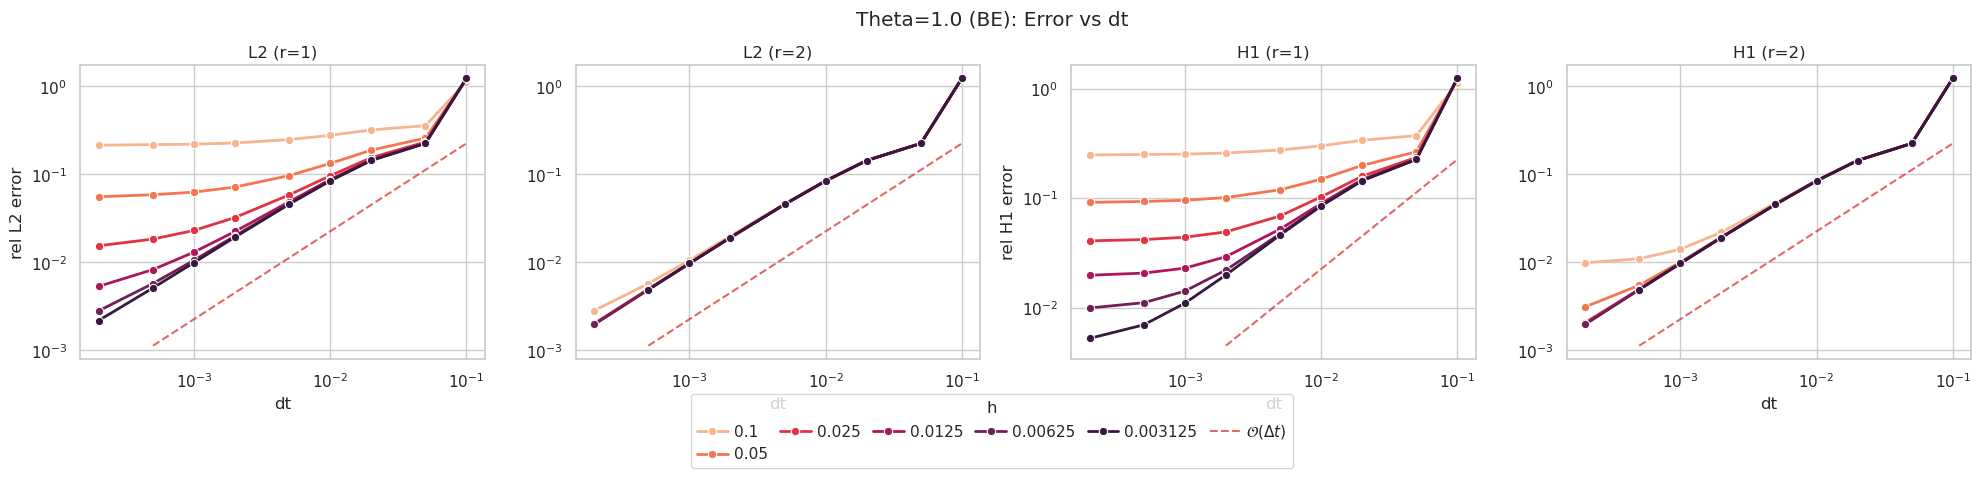

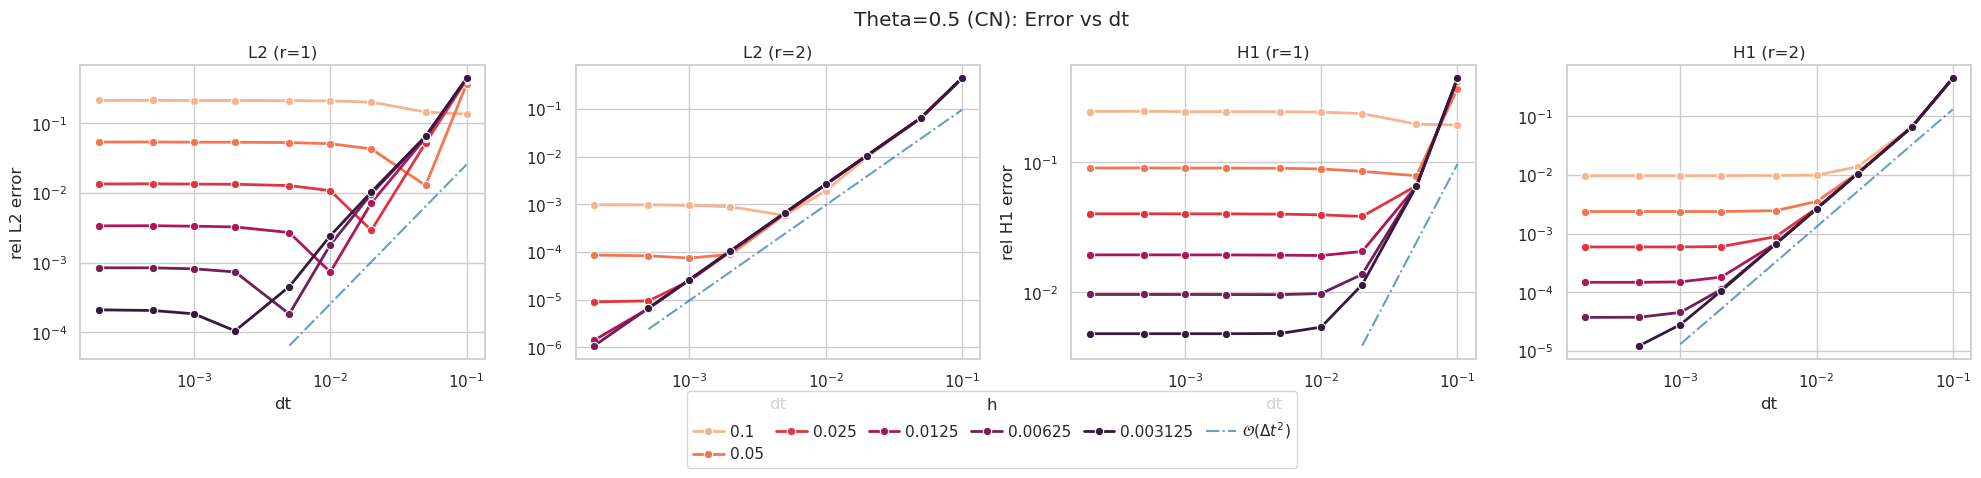

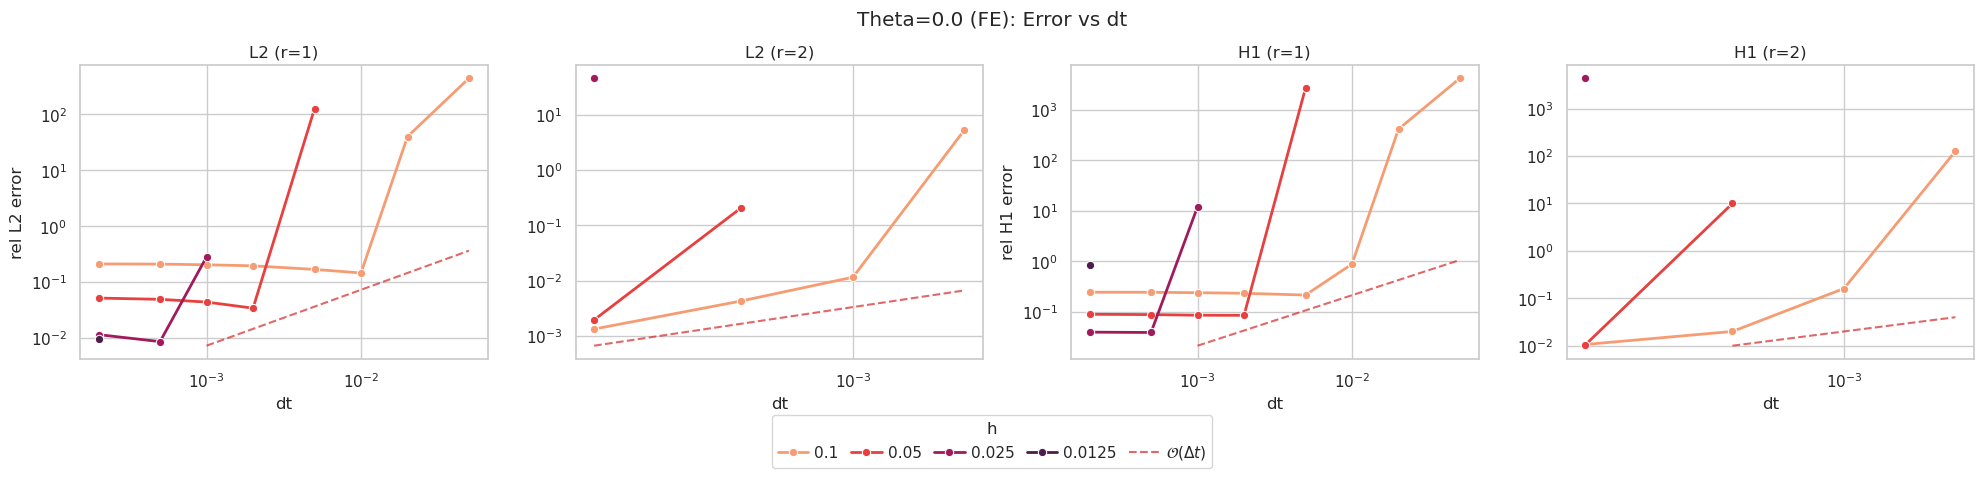

In [170]:
# Line charts for Theta subsets
figs_be = plot_lines_by_r(df_theta_BE, 'Theta=1.0 (BE)', ref_dt_order=1)
print()
figs_cn = plot_lines_by_r(df_theta_CN, 'Theta=0.5 (CN)', ref_dt_order=2)
print()
figs_fe = plot_lines_by_r(df_theta_FE, 'Theta=0.0 (FE)', ref_dt_order=1)

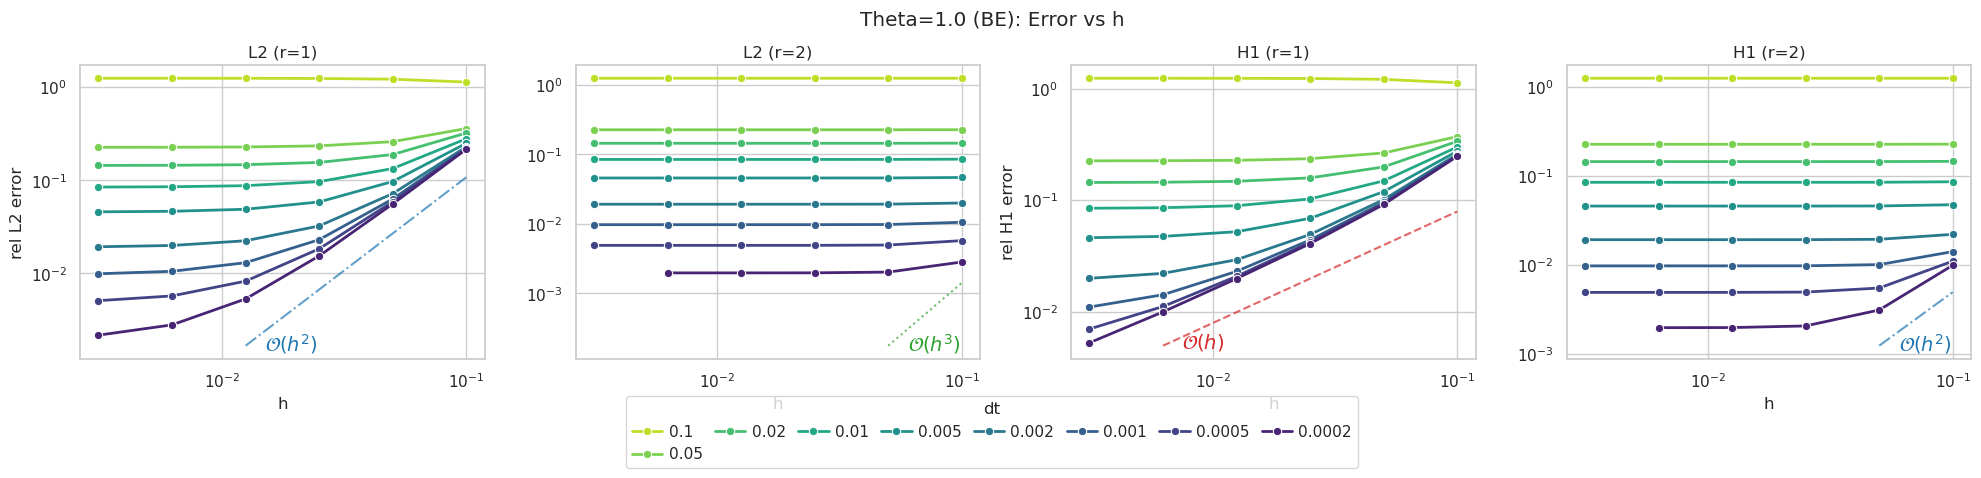

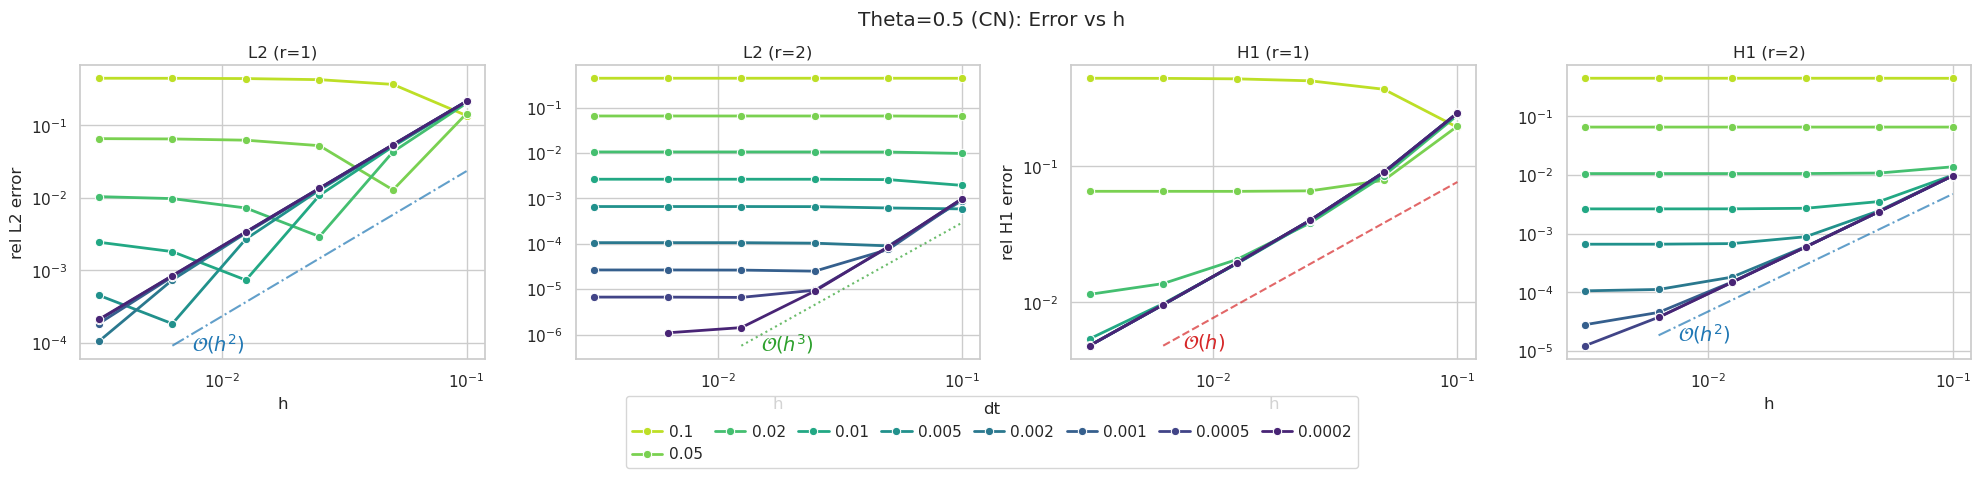

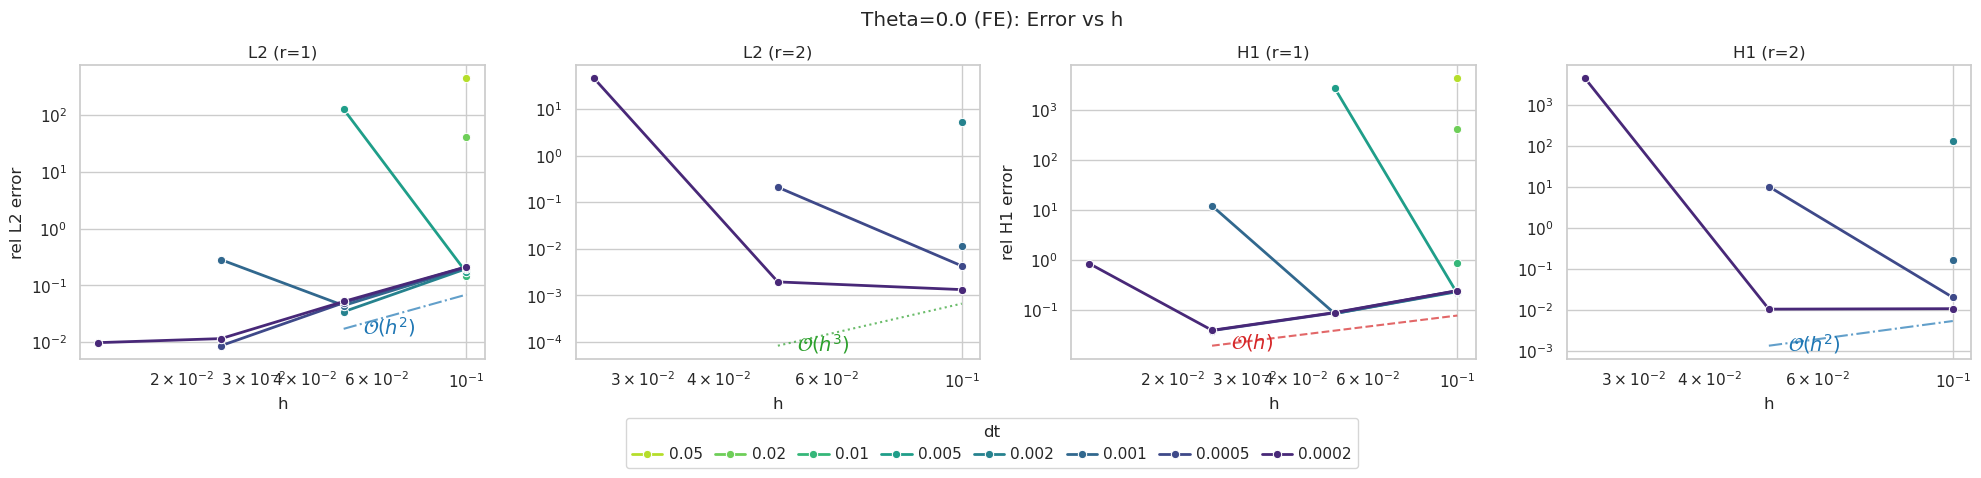

In [171]:
# Spatial line charts for Theta subsets (h on x-axis, dt as colour)
g = plot_lines_by_r_spatial(df_theta_BE, 'Theta=1.0 (BE)')
print()
g = plot_lines_by_r_spatial(df_theta_CN, 'Theta=0.5 (CN)')
print()
g = plot_lines_by_r_spatial(df_theta_FE, 'Theta=0.0 (FE)')

In [172]:
# # Rate-style plots: isolate h^r and dt^2 behavior (Theta)
# for dfi, name in [(df_theta_BE, 'Theta=1.0 (BE)'), (df_theta_CN, 'Theta=0.5 (CN)'), (df_theta_FE, 'Theta=0.0 (FE)')]:
#     plot_spacetime_rates(dfi, name, 'rel_L2_error_final')
#     plot_spacetime_rates(dfi, name, 'rel_H1_error_final')


In [173]:
# # Heatmaps for Theta subsets
# plot_heatmaps(df_theta_BE, 'Theta=1.0 (BE)')
# print()
# plot_heatmaps(df_theta_CN, 'Theta=0.5 (CN)')
# print()
# plot_heatmaps(df_theta_FE, 'Theta=0.0 (FE)')

In [174]:
def plot_collapsed_convergence(df, err_col, scheme_name):
    """
    Plots Error vs (h^s + dt^t) to verify the combined convergence rate.
    If the estimate holds, points should collapse onto a line with slope 1.
    
    Logic for orders:
      - Spatial (s): L2 -> r+1, H1 -> r
      - Temporal (t): Theta=0/1 -> 1, others (Newmark, CN) -> 2
    """
    df_clean, _ = filter_diverged(df)
    if df_clean.empty:
        print(f"[{scheme_name}] No valid data.")
        return

    # Determine spatial order offset
    if 'L2' in err_col:
        s_offset = 1
        metric_label = "L2"
    else:
        s_offset = 0
        metric_label = "H1"

    # Determine temporal order based on scheme name
    # Theta=1.0 (BE) and Theta=0.0 (FE) are 1st order in time.
    # Newmark and Theta=0.5 (CN) are 2nd order.
    if "Theta=1.0" in scheme_name or "Theta=0.0" in scheme_name:
        t_order = 1.0
    else:
        t_order = 2.0
    
    r_vals = sorted(df_clean['r'].unique())
    fig, ax = plt.subplots(figsize=(7, 5))
    
    # Collect all x, y for reference line scaling
    all_x, all_y = [], []

    for r_val in r_vals:
        sub = df_clean[df_clean['r'] == r_val].copy()
        if sub.empty:
            continue
        
        s_power = r_val + s_offset
        
        # The combined metric: h^(r+offset) + dt^t_order
        x_vals = sub['h']**s_power + sub['dt']**t_order
        y_vals = sub[err_col]
        
        all_x.extend(x_vals)
        all_y.extend(y_vals)
        
        sns.scatterplot(x=x_vals, y=y_vals, label=f'r={r_val}', ax=ax, s=50, alpha=0.8)

    if not all_x:
        return

    all_x = np.array(all_x)
    all_y = np.array(all_y)
    
    # 1. Reference line with slope 1 (Upper Bound)
    C_est = np.max(all_y / all_x)
    x_ref = np.geomspace(all_x.min(), all_x.max(), 50)
    y_ref = C_est * x_ref
    ax.plot(x_ref, y_ref, 'k--', alpha=0.6, label=f'Theoretical Slope 1')

    # 2. Best fit line (Observed Slope)
    mask = (all_x > 0) & (all_y > 0)
    if np.sum(mask) > 1:
        lx = np.log(all_x[mask])
        ly = np.log(all_y[mask])
        slope, intercept = np.polyfit(lx, ly, 1)
        
        y_fit = np.exp(intercept) * x_ref**slope
        ax.plot(x_ref, y_fit, 'r:', linewidth=2, label=f'Observed Slope ~ {slope:.2f}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Dynamic label
    s_str = "r+1" if s_offset == 1 else "r"
    t_str = f"{int(t_order)}"
    ax.set_xlabel(f'$h^{{{s_str}}} + \\Delta t^{{{t_str}}}$')
    
    ax.set_ylabel(err_col)
    ax.set_title(f'{scheme_name}: Collapsed Convergence ({metric_label})')
    ax.legend()
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.show()

## Collapsed convergence check

Plotting error vs $h^s + \Delta t^q$ (where $s$ is the spatial order and $q$ the temporal order) should collapse all data points onto a line of slope 1 if the theoretical bound $\|e\| \leq C(h^s + \Delta t^q)$ holds.

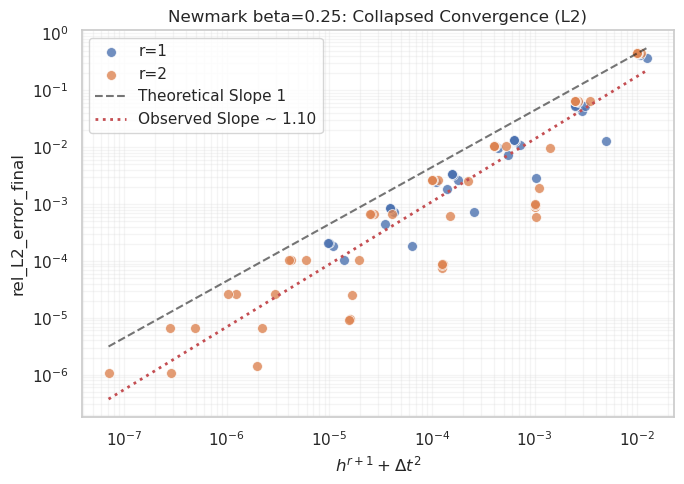

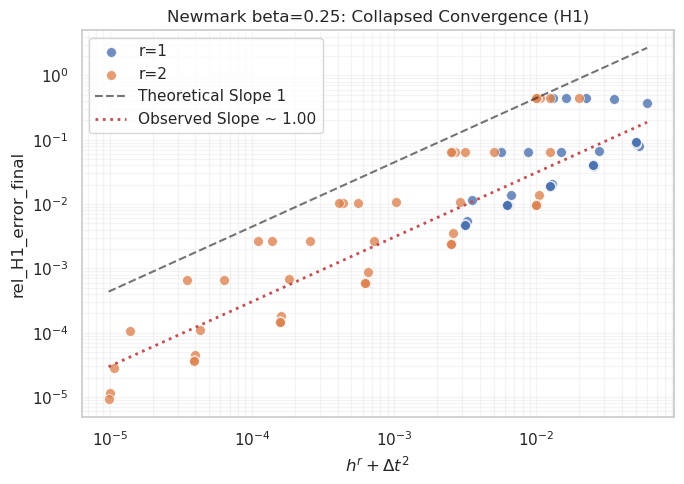

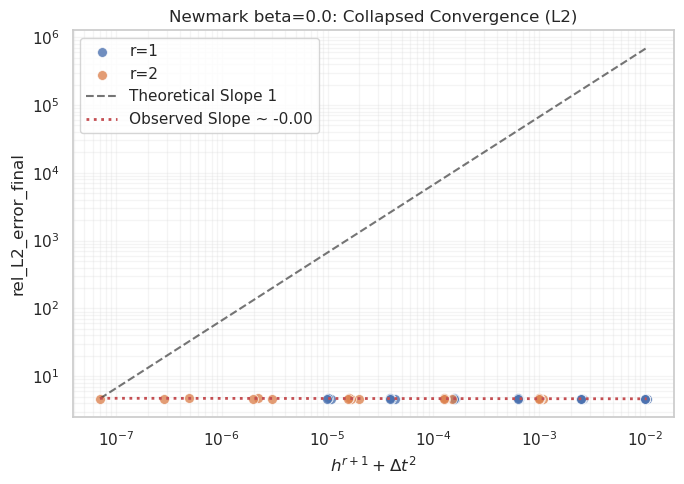

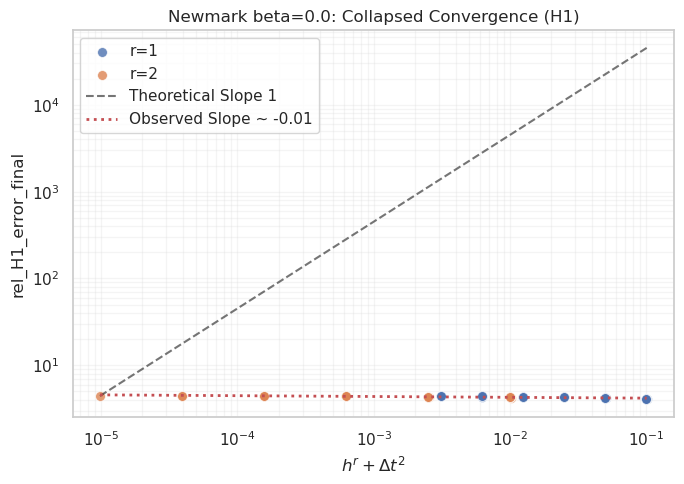

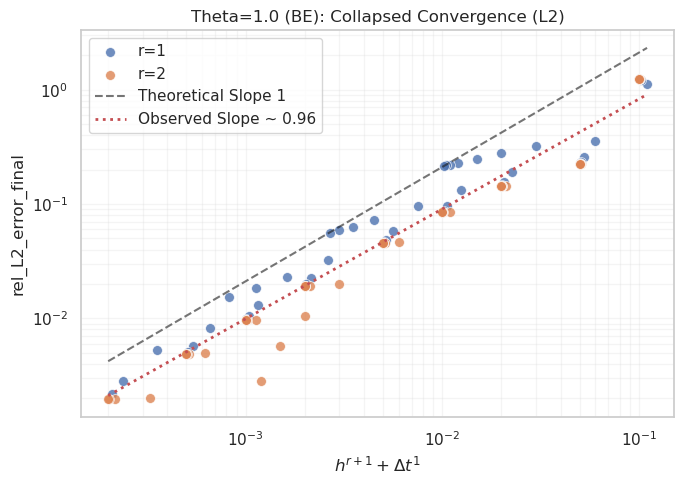

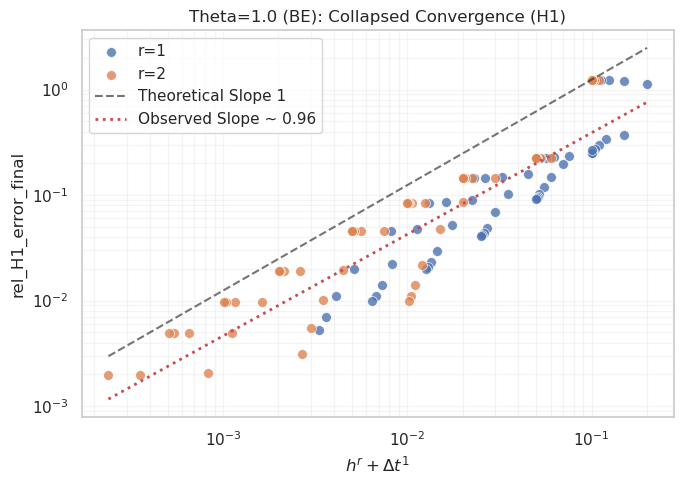

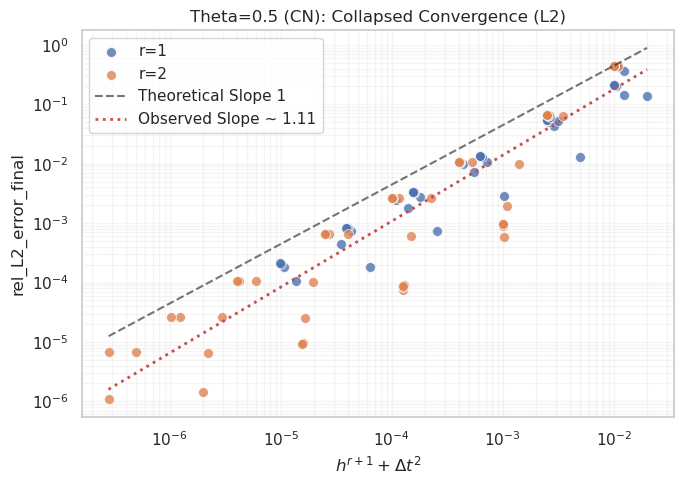

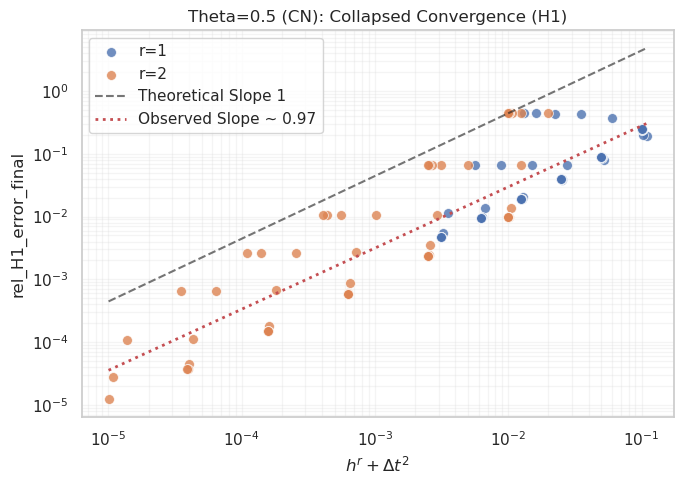

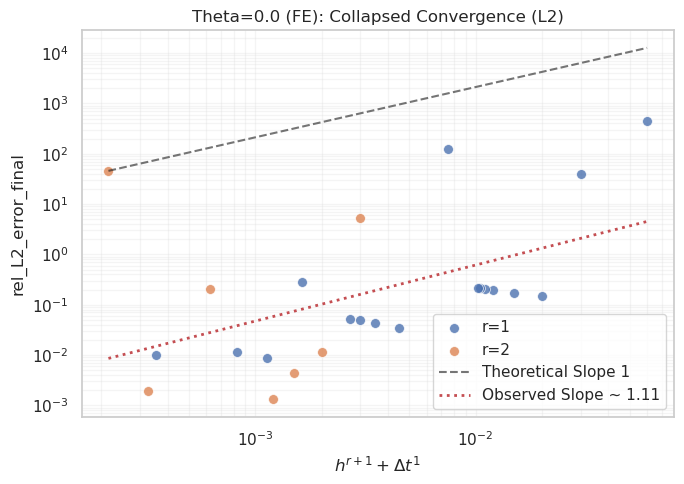

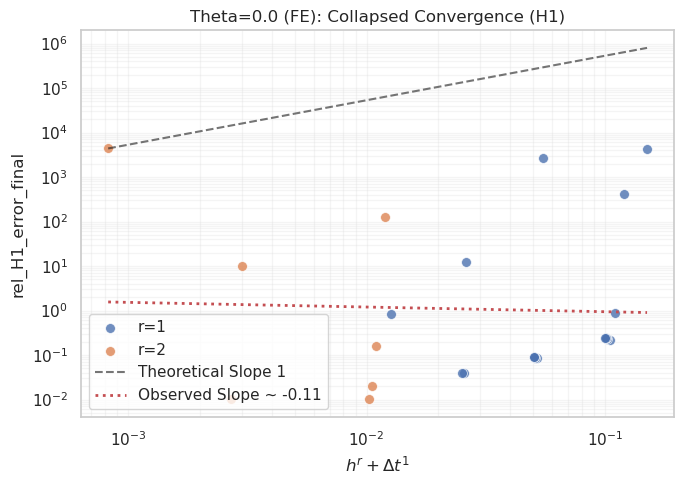

In [175]:
# Collapsed convergence for all 5 schemes (L2 and H1)
for dfi, name in [
    (df_newmark_025, 'Newmark beta=0.25'),
    (df_newmark_000, 'Newmark beta=0.0'),
    (df_theta_BE, 'Theta=1.0 (BE)'),
    (df_theta_CN, 'Theta=0.5 (CN)'),
    (df_theta_FE, 'Theta=0.0 (FE)'),
]:
    plot_collapsed_convergence(dfi, 'rel_L2_error_final', name)
    plot_collapsed_convergence(dfi, 'rel_H1_error_final', name)